In [4]:
pip install tensorflow keras opencv-python numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\lalli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import cv2
import os
import matplotlib.pyplot as plt

In [6]:
# Corrected dataset path
train_path = "C:\\Users\\lalli\\OneDrive\\Desktop\\MALARIA\\Dataset\\Train"
categories = ["Parasite", "Uninfected"]

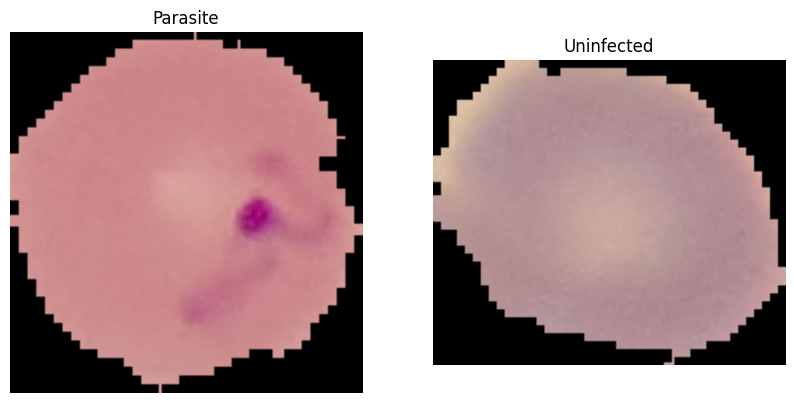

In [8]:
# Set up the figure
plt.figure(figsize=(10, 5))

for i, category in enumerate(categories):
    # Get the first image from each category
    category_path = os.path.join(train_path, category)
    
    if not os.path.exists(category_path):
        print(f"Folder not found: {category_path}")
        continue

    image_files = os.listdir(category_path)

    if len(image_files) == 0:
        print(f"No images found in {category}!")
        continue
    
    # Load and process the image
    image_path = os.path.join(category_path, image_files[0])
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image
    plt.subplot(1, 2, i + 1)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(category)

plt.show()

Resize and Normalize Images

In [9]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Define dataset path
train_path = "C:\\Users\\lalli\\OneDrive\\Desktop\\MALARIA\\Dataset\\Train"
categories = ["Parasite", "Uninfected"]

In [11]:
# Set image size (for MobileNetV2)
IMG_SIZE = 224

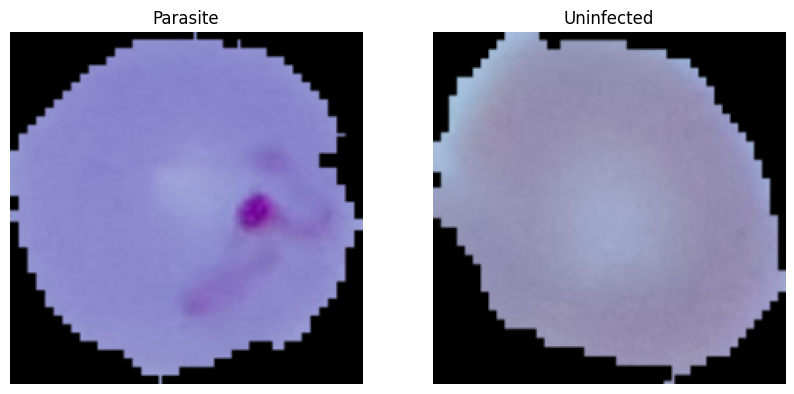

In [12]:
# Load, resize, and normalize a sample image from each category
plt.figure(figsize=(10, 5))

for i, category in enumerate(categories):
    category_path = os.path.join(train_path, category)
    image_files = os.listdir(category_path)

    if len(image_files) == 0:
        print(f"No images found in {category}!")
        continue
    
    # Load the first image
    image_path = os.path.join(category_path, image_files[0])
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    image = image / 255.0  # Normalize pixel values to [0,1]

    # Display image
    plt.subplot(1, 2, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(category)

plt.show()

Apply Data Augmentation (Rotation, Flipping, Zooming)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# Define ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values (0-1)
    rotation_range=20,   # Rotate images up to 20 degrees
    width_shift_range=0.2, # Shift width by 20%
    height_shift_range=0.2, # Shift height by 20%
    horizontal_flip=True,  # Flip images horizontally
    zoom_range=0.2,       # Zoom in/out up to 20%
    shear_range=0.2       # Shear transformation
)

In [15]:
# Load train dataset with augmentation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),   # Resize images
    batch_size=32,            # Load images in batches
    class_mode='binary'       # Binary classification (Parasite vs Uninfected)
)

Found 416 images belonging to 2 classes.


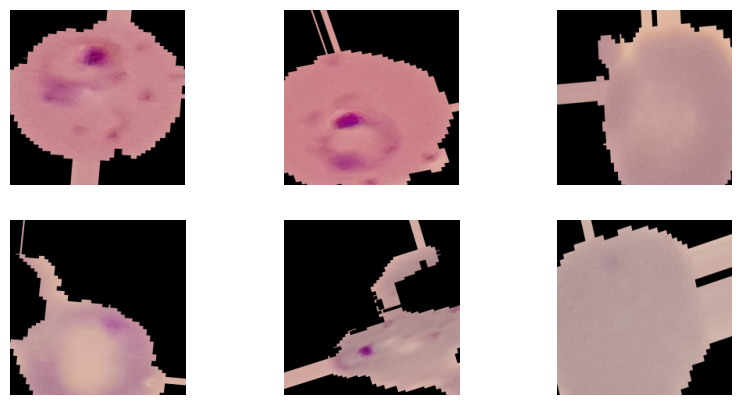

In [16]:
# Display augmented images
x_batch, y_batch = next(train_generator)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

for i in range(6):  # Show first 6 images
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis("off")

plt.show()

Model Definition

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [18]:
# Load the MobileNetV2 model (without the top classifier)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [19]:
# Freeze the base model layers (so they don’t get retrained)
base_model.trainable = False

In [20]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(128, activation='relu')(x)  # Add a dense layer
x = Dense(64, activation='relu')(x)  # Another dense layer
output_layer = Dense(1, activation='sigmoid')(x)  # Output layer (binary classification)

In [21]:
# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

In [22]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [23]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model Training Code

In [24]:
# Define validation data generator (without augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
# Load validation dataset
val_path = "C:\\Users\\lalli\\OneDrive\\Desktop\\MALARIA\\Dataset\\Test"  # Update if needed

In [26]:
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 134 images belonging to 2 classes.


In [27]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust based on performance
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

c:\Users\lalli\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6224 - loss: 0.6323 - val_accuracy: 0.8731 - val_loss: 0.4696
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8910 - loss: 0.4347 - val_accuracy: 0.8955 - val_loss: 0.3942
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9034 - loss: 0.3422 - val_accuracy: 0.8955 - val_loss: 0.3286
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9136 - loss: 0.3010 - val_accuracy: 0.8657 - val_loss: 0.3479
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8885 - loss: 0.3109 - val_accuracy: 0.8806 - val_loss: 0.2917
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9278 - loss: 0.2398 - val_accuracy: 0.9179 - val_loss: 0.2239
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9550 - loss: 0.1944 - val_accuracy: 0.9030 - val_loss: 0.2575
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9253 - loss: 0.1993 - val_accuracy: 0.9254 - val_loss:

Evaluate the Model

In [28]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8853 - loss: 0.2575
Test Accuracy: 0.8955
Test Loss: 0.2404


In [29]:
# Plot Training vs Validation Accuracy & Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

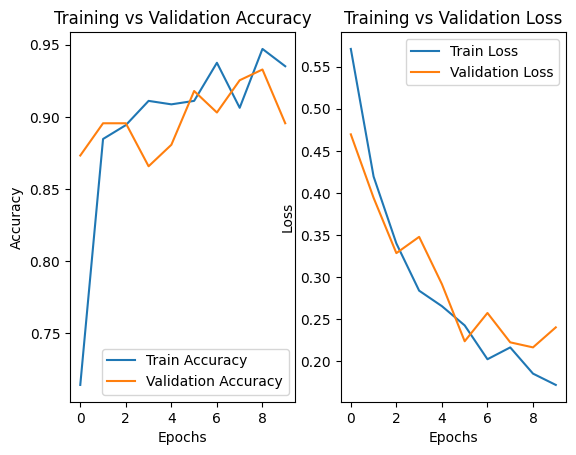

In [30]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

Compute Confusion Matrix & Classification Report

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
# Get true labels and predicted labels
y_true = val_generator.classes  # Actual class labels
y_pred_probs = model.predict(val_generator)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

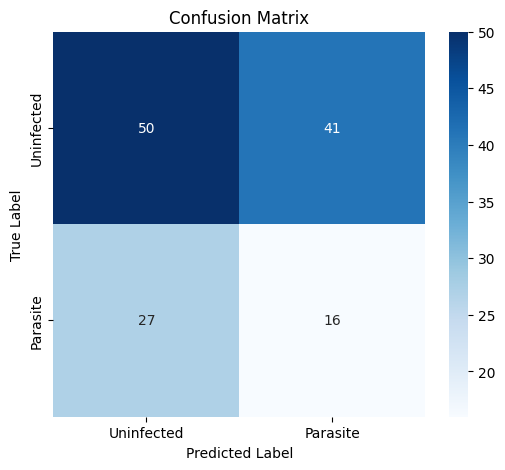

In [35]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasite'], yticklabels=['Uninfected', 'Parasite'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [36]:
# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasite']))

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.65      0.55      0.60        91
    Parasite       0.28      0.37      0.32        43

    accuracy                           0.49       134
   macro avg       0.47      0.46      0.46       134
weighted avg       0.53      0.49      0.51       134



Plot ROC Curve

In [37]:
from sklearn.metrics import roc_curve, auc

In [38]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

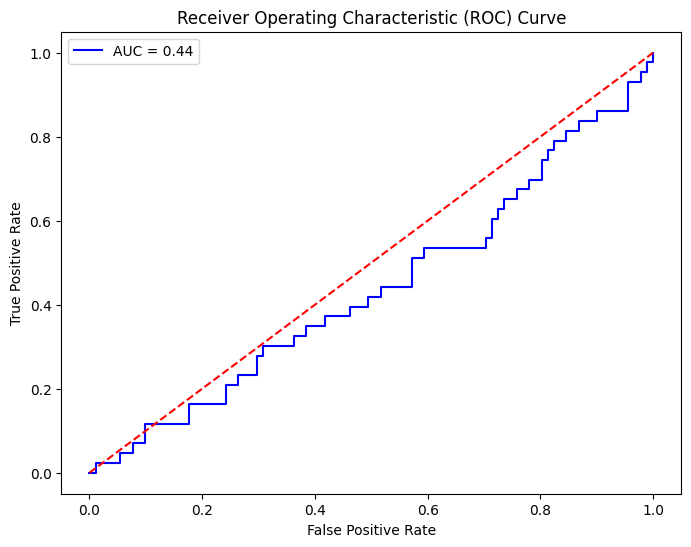

In [39]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random model reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Test Predictions on a New Image

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# Load an image (Change the path to any new image)
image_path = "C:\\Users\\lalli\\Downloads\\archive (2)\\Dataset\\Test\\Parasite\\C39P4thinF_original_IMG_20150622_110115_cell_138.png"

In [57]:
# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))  # Resize to 224x224
image = image / 255.0  # Normalize pixel values (0-1)
image = np.expand_dims(image, axis=0)  # Expand dimensions for model input

In [58]:
# Make prediction
prediction = model.predict(image)[0][0]  # Get probability score
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.0037285713


In [59]:
# Determine class label
label = "Parasite" if prediction < 0.5 else "Uninfected"

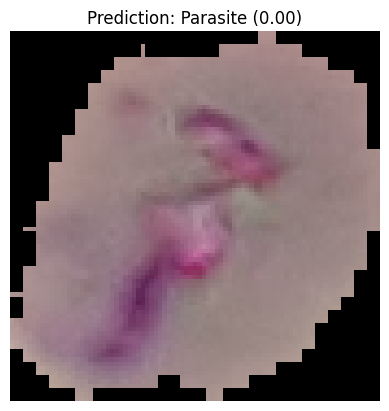

In [60]:
# Display image with prediction
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {label} ({prediction:.2f})")
plt.axis("off")
plt.show()

In [50]:
# Save model in TensorFlow format
model.save("malaria_cell_classifier.h5")
print("Model saved successfully!")

Model saved successfully!
